# **Website A/B Testing for Conversion Optimization**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt, time
from statsmodels.stats.proportion import proportions_ztest

In [ ]:
np.random.seed(42)

In [ ]:
#Assume 10,000 visitors each
n_A, p_A = 10000, 0.10  # variant A: 10% true conversion
n_B, p_B = 10000, 0.12  # variant B: 12% true conversion

Variant A: The original checkout page

Variant B: The new version that we're testing

Here, each version had 10,000 visitors.

Version A has true conversion rate of 10%.
Version B has true conversion rate of 12%

In [ ]:
#Simulate number of purchases

success_A = np.random.binomial(n_A, p_A)
success_B = np.random.binomial(n_B, p_B)

In [ ]:
# Calculate conversion rate
def proportion_ci(success, n, alpha=0.05):
  p_hat = success / n
  z = stats.norm.ppf(1-alpha/2)
  se = np.sqrt(p_hat*(1-p_hat)/n)
  return p_hat, p_hat-z*se, p_hat+z*se
  #lower = p_hat - z * se
  #upper = p_hat + z * se

In [ ]:
p_A_hat, ci_low_A, ci_high_A = proportion_ci(success_A, n_A)
p_B_hat, ci_low_B, ci_high_B = proportion_ci(success_B, n_B)

In [ ]:
results = pd.DataFrame({
    "Variant": ["A", "B"],
    "Visitors": [n_A, n_B],
    "Conversions": [success_A, success_B],
    "Conversion Rate": [p_A_hat, p_B_hat],
    "Lower CI": [ci_low_A, ci_low_B],
    "Upper CI": [ci_high_A, ci_high_B]
})
print(results)

  Variant  Visitors  Conversions  Conversion Rate  Lower CI  Upper CI
0       A     10000          973           0.0973  0.091491  0.103109
1       B     10000         1134           0.1134  0.107185  0.119615


For Variant A, about 9.73% of the people purchased something and for Variant B, about 11.34% people purchased.

We are 95% sure that the true conversion rate lies within the listed range for each version.

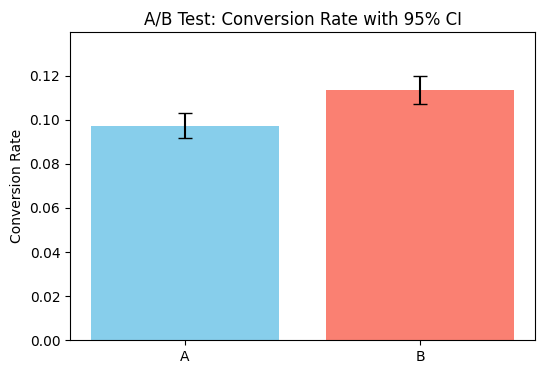

In [ ]:
# Plot Conversion rates with error bars

plt.figure(figsize=(6,4))
plt.bar(
    results["Variant"],
    results["Conversion Rate"],
    yerr = [
        results["Conversion Rate"] - results["Lower CI"],
        results["Upper CI"] - results["Conversion Rate"]],
    capsize=5,
    color = ['skyblue', 'salmon']
)
plt.ylabel("Conversion Rate")
plt.title("A/B Test: Conversion Rate with 95% CI")
plt.ylim(0, max(results['Upper CI']) + 0.02)
plt.show()

Here, two bars: variant A and Variant B is shown. The Height of the bar gives observed conversion rate and the vertical line above(error bar) is the 95% confidence interval. The bar shows the average results and the error line shows the uncertainty.

Also, if these bars don't overlap then it suggests that Variant B is significantly better than A.

### **Two Proportion Test (Z-test)**

In [ ]:
#Test H0: p_B <= p_A vs H1: p_B > p_A
count = np.array([success_B, success_A])
#count: the number of purchase for each variant

nobs = np.array([n_B, n_A])
#nobs: the number of visitors for each variant

z_test, p_value = proportions_ztest(count, nobs, alternative="larger")
print(f"Z-test statistic: {z_test:.3f}")
print(f"P-value: {p_value:.3f}")

if p_value < 0.05:
  print("\n Reject null hypothesis [H0]")
  print(" Variant B has a significantly higher conversion rate.")
else:
  print("\nFail to reject null hypothesis [H0]")
  print(" No significant lift from B over A")

Z-test statistic: 3.708
P-value: 0.000

 Reject null hypothesis [H0]
 Variant B has a significantly higher conversion rate.


This test tells us that Variant B is better than Variant A.
The result is very strong, that is we are confident that the new version (Variant B) leads to more purchases compared to the original version (Variant A).

### **Real-Time Monitoring and Sequential testing**

In [ ]:
# Simulate data arriving in small batches
  # (eg. 100 visitors per variant per minute),
  # update the cumulative conversions and totals,
  # return the two-proportion z-test each time,
  # and visualize how both the p-value and the observed lift evolve.

from IPython.display import clear_output

# Use the same true rates from above
true_p_A, true_p_B = 0.10, 0.12
batch_size = 100    #visitors per batch per variant
n_batches = 60      #simulate 60 time steps (eg. minutes)

# Initialize counters
n_visits_A = n_visits_B = 0
n_success_A = n_success_B = 0

# Lists to store matrices for plotting
batches = []
p_values = []
observed_lifts = []


In [ ]:
for batch in range(1, n_batches+1):
  # Simulate one batch of visitors
  new_A = np.random.binomial(batch_size, true_p_A)
  new_B = np.random.binomial(batch_size, true_p_B)

  # Update totals
  n_visits_A += batch_size
  n_visits_B += batch_size
  n_success_A += new_A
  n_success_B += new_B

  # Compute current conversion rates
  cr_A = n_success_A / n_visits_A     # Total conversion rate for A
  cr_B = n_success_B / n_visits_B     # Total conversion rate for B
  lift = cr_B - cr_A      # How much better B is than A

  # Two proportion z-test
  count = np.array([n_success_B, n_success_A])
  nobs = np.array([n_visits_B, n_visits_A])
  z_test, p_value = proportions_ztest(count, nobs, alternative="larger")
# Test: Is Version B doing significantly better than A
# z_test: How strong the difference is
# p_value: How likely the difference is due to random choice

  # Append to lists for plotting
  batches.append(batch)
  p_values.append(p_value)
  observed_lifts.append(lift)

  # Clear previous o/p and print current state
  clear_output(wait=True)
  print(f"Batch {batch}/{n_batches}")
  print(f"Variant A: {n_visits_A} visitors, {n_success_A} buys -> Conversions = {cr_A:.3%}")
  print(f"Variant B: {n_visits_B} visitors, {n_success_B} buys -> Conversions = {cr_B:.3%}")
  print(f"Observed Lift: {lift:.3%}")
  print(f"Z-test = {z_test:.2f}, p-value = {p_value:.4f}")

  if p_value < 0.05:
    print(" Significant lift detected (p<0.05).")
  else:
    print(" No significant lift detected.")

Batch 60/60
Variant A: 6000 visitors, 574 buys -> Conversions = 9.567%
Variant B: 6000 visitors, 714 buys -> Conversions = 11.900%
Observed Lift: 2.333%
Z-test = 4.13, p-value = 0.0000
 Significant lift detected (p<0.05).


The new version (Variant B) is significantly better than the original version (Variant A).
We observed that Variant B resulted in a higher number of people completing a purchase compared to Variant A.
The statistical test confirmed this difference is not just random chance, but a real improvement.
Therefore, we are confident that switching to the new version (Variant B) will lead to more sales.

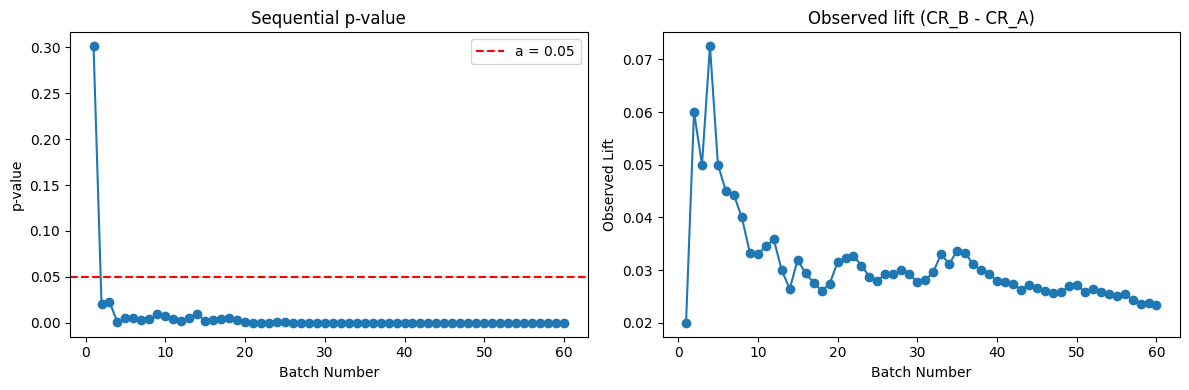

In [ ]:
# Plot p-value and lift over batches
import time

Fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(batches, p_values, marker='o')
axes[0].axhline(0.05, color='red', linestyle='--', label='a = 0.05')
axes[0].set_xlabel('Batch Number')
axes[0].set_ylabel('p-value')
axes[0].set_title('Sequential p-value')
axes[0].legend()

axes[1].plot(batches, observed_lifts, '-o')
axes[1].set_xlabel('Batch Number')
axes[1].set_ylabel('Observed Lift')
axes[1].set_title('Observed lift (CR_B - CR_A)')

plt.tight_layout()
plt.show()

# Pause briefly to simulate real time
time.sleep(0.9)

### **Conclusion:**
We conducted an A/B test comparing two webpage versions— Variant A and Variant B. Each variant had 10,000 simulated visitors, with true conversion rates of 10% for A and 12% for B.

We generated purchase data based on these rates and calculated the observed conversion rates along with their 95% confidence intervals. These intervals show the range where the true conversion rates likely fall.

We visualized the conversion rates with error bars. Non-overlapping intervals suggested a meaningful difference.

To confirm this, we performed a two-proportion z-test, which showed that Variant B's higher conversion rate is statistically significant and not just random chance.

Finally, We simulated data arriving in batches to see how the results would change over time as more data comes in. This helps in understanding a real-world scenario.

###**Learning:**

~ The main conclusion that is drawn is that the new version (Variant B) led to a significantly higher conversion rate compared to the original version (Variant A).

~ The z-test provided strong evidence that Variant B is genuinely better and not just random.

~ Based on the strong results from this A/B test, Variant B should be implemented for all users on the live website instead of Variant A.

